# DGV-PT2
Notebook per la previsione di `time2` su griglia variabile.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/input/DGV_PT2_train.csv")
test_df = pd.read_csv("data/input/DGV_PT2_test.csv")
all_df = pd.concat([train_df, test_df])

## Stima
Il primo modello che consideriamo è la stima basata sulla proporzione rispetto al modello operativo, detta previsione ottimistica (PO).

In [2]:
def optimistic_estimate(df):
    ni = df.x_length / df.grid_step
    nj = df.y_length / df.grid_step
    n_procs = df.n_nodes * df.n_cores
    return 59.8 * (20/df.grid_step) * (ni*nj/403776) * (864/n_procs) * (1 - 0.3*df.single_precision)

In [3]:
test_res_oe = test_df.copy()
test_res_oe["target"] = test_res_oe.time2
test_res_oe["prediction"] = optimistic_estimate(test_df)
test_res_oe["residual"] = test_res_oe.target - test_res_oe.prediction
test_res_oe["relative"] = test_res_oe.residual / test_res_oe.target
test_res_oe["abs_err"] = (test_res_oe.target - test_res_oe.prediction).abs()
test_res_oe["rel_err"] = test_res_oe.abs_err / test_res_oe.target
test_res_oe[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,9.802852,0.271033
std,19.238842,0.194615
min,0.004431,0.000649
25%,0.499971,0.108545
50%,1.513882,0.236828
75%,9.459861,0.404457
max,122.857660,0.899692


In [4]:
print("RMSE:", np.sqrt((test_res_oe.abs_err ** 2).mean()))

RMSE: 21.58376307980503


Possiamo notare come il modello sovrastimi la previsione quasi sempre.

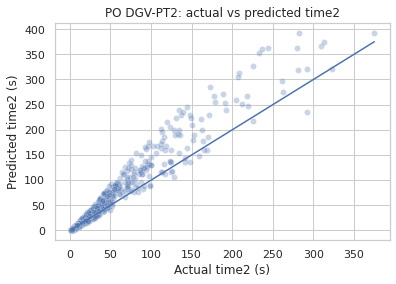

In [5]:
plt.title("PO DGV-PT2: actual vs predicted time2")
plt.plot([0, test_res_oe.target.max()], [0, test_res_oe.target.max()])
sns.scatterplot(data=test_res_oe, x="target", y="prediction", alpha=0.3)
plt.xlabel("Actual time2 (s)")
plt.ylabel("Predicted time2 (s)")
plt.savefig("tex/images/dgv-pt2/po-correlazione-osservazione-previsione.pdf")
plt.show()

Il grafico dei residui presenta un evidente pattern lineare: maggiore il tempo di esecuzione, maggiore la sovrastima.

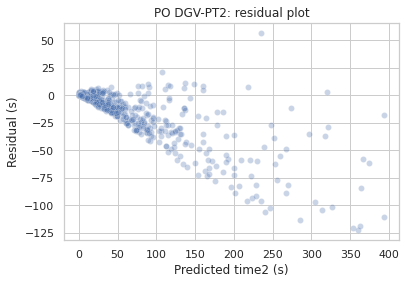

In [6]:
plt.title("PO DGV-PT2: residual plot")
sns.scatterplot(data=test_res_oe, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time2 (s)")
plt.ylabel("Residual (s)")
plt.show()

## Regressione lineare
Il primo modello da considerare è la regressione lineare.

In [7]:
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
data = CosmoData(train_df, None, test_df)
reg = reg.fit(data.train_set()[0], data.train_set()[1])

test_res_lr = test_df.copy()
test_res_lr["target"] = test_res_lr.time2
test_res_lr["prediction"] = np.exp(reg.predict(data.test_set()[0]))
test_res_lr["residual"] = test_res_lr.target - test_res_lr.prediction
test_res_lr["abs_err"] = (test_res_lr.target - test_res_lr.prediction).abs()
test_res_lr["rel_err"] = test_res_lr.abs_err / test_res_lr.target
test_res_lr[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,10.216077,0.388431
std,23.209618,0.318654
min,0.002783,0.000376
25%,0.789869,0.131812
50%,2.676113,0.322604
75%,8.246880,0.551741
max,254.620552,1.496962


In [8]:
print("RMSE:", np.sqrt((test_res_lr.abs_err ** 2).mean()))

RMSE: 25.347897114309816


Il grafico del tempo previsto e del tempo osservato mostra come la regressione lineare sottostimi i tempi più lunghi e come tale errore aumenti all'aumentare del tempo osservato.

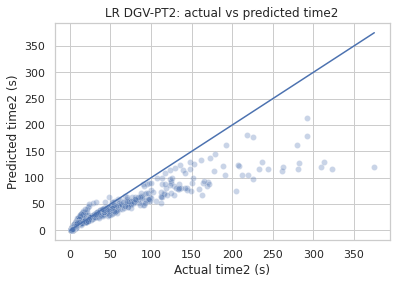

In [9]:
plt.title("LR DGV-PT2: actual vs predicted time2")
plt.plot([0, test_res_lr.target.max()], [0, test_res_lr.target.max()])
sns.scatterplot(data=test_res_lr, x="target", y="prediction", alpha=0.3)
plt.xlabel("Actual time2 (s)")
plt.ylabel("Predicted time2 (s)")
plt.savefig("tex/images/dgv-pt2/lr-correlazione-osservazione-previsione.pdf")
plt.show()

Possiamo notare la medesima cosa analizzando il grafico dei residui. Inoltre possiamo notare come si presente un pattern che suggerisce non linearità: il grafico del confronto tra previsione e residuo dovrebbe avere un aspetto casuale, proprio perché l'errore della previsione dovrebbe essere casuale.

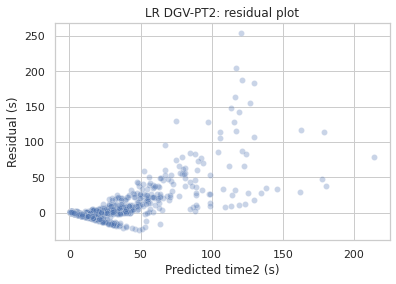

In [10]:
plt.title("LR DGV-PT2: residual plot")
sns.scatterplot(data=test_res_lr, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time2 (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgv-pt2/lr-grafico-residui.pdf")
plt.show()

Si può invece notare come la distribuzione dell'errore segua circa una distribuzione normale, al contrario dell'errore relativo.

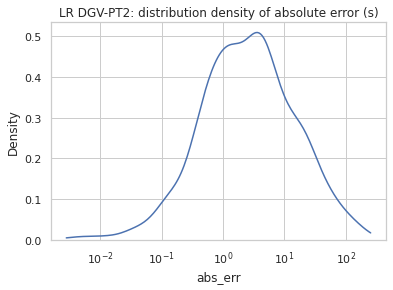

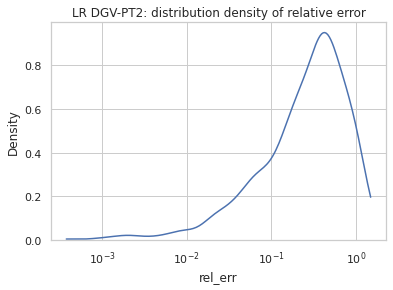

In [11]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.xscale("log")
plt.title("LR DGV-PT2: distribution density of absolute error (s)")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.title("LR DGV-PT2: distribution density of relative error")
plt.show()

## DGV-PT2 senza HP tuning

La prima prova con un FCNN viene fatta usando due hidden layer, addestrata per 500 epoch.

In [12]:
config = {
    "batch": "full",
    "optimizer": {
        "name": "adam",
        "lr": 0.05,
        "weight_decay": 0.0
    },
    "loss": "mse",
    "model": {
        "layers": [{
            "size": 14,
            "dropout": 0.0,
        }, {
            "size": 7,
            "dropout": 0.0
        }]
    }
}
data = CosmoData(train_df, None, test_df, config["batch"])
model = CosmoPredictor(data.input_size, config)
train_res_noopt = model.fit(data, 500)
test_res_noopt = model.test(data)

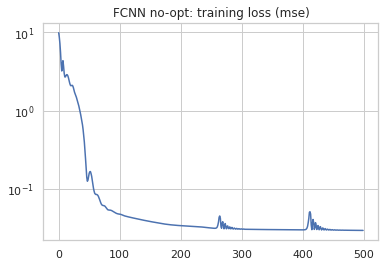

In [13]:
train_res_noopt.train_loss.plot(grid=True, logy=True)
plt.title(f"FCNN no-opt: training loss ({config['loss']})")
plt.show()

Si può notare un miglioramento rispetto al modello LR guardando il massimo e il 75° percentile dell'errore massimo e relativo.

In [14]:
test_res_noopt["abs_err"] = (test_res_noopt.target - test_res_noopt.prediction).abs()
test_res_noopt["rel_err"] = test_res_noopt.abs_err / test_res_noopt.target
test_res_noopt["residual"] = test_res_noopt.target - test_res_noopt.prediction
test_res_noopt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,5.551620,0.135784
std,14.631205,0.097080
min,0.000047,0.000028
25%,0.282317,0.056344
50%,0.801192,0.121842
75%,3.524993,0.194102
max,187.963974,0.506531


Il RMSE si è quasi dimezzato rispetto al LR.

In [15]:
print("RMSE:", np.sqrt((test_res_noopt.abs_err ** 2).mean()))

RMSE: 15.642204439554213


Lo stesso miglioramento si può apprezzare anche guardando il grafico tra tempo osservato e previsto, in cui è meno marcato il progressivo aumento dell'errore all'aumentare del tempo osservato.

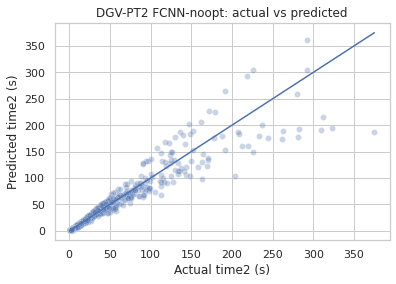

In [16]:
plt.title("DGV-PT2 FCNN-noopt: actual vs predicted")
plt.plot([test_res_noopt.target.min(), test_res_noopt.target.max()], [test_res_noopt.target.min(), test_res_noopt.target.max()])
sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.prediction, alpha=0.3)
plt.xlabel("Actual time2 (s)")
plt.ylabel("Predicted time2 (s)")
plt.savefig("tex/images/dgv-pt2/fcnn-noopt-correlazione-osservazione-previsione.pdf")
plt.show()

Anche il grafico dei residui rispetto al valore predetto presenta pattern meno evidenti.

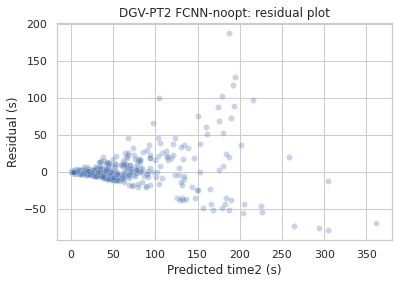

In [17]:
plt.title("DGV-PT2 FCNN-noopt: residual plot")
sns.scatterplot(data=test_res_noopt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time2 (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgv-pt2/fcnn-noopt-grafico-residui.pdf")
plt.show()

## DGV-PT2 con HP tuning
Il modello è stato sottoposto a hyperparameter tuning con Bayesian Optimization. Come funzione obiettivo da minimizzare è stato considerato unicamente RMSE, in quanto si è interessati a minimizzare l'errore per le esecuzioni più lunghe e a non avere outlier. Per ogni tentativo, è stato effettuato il 10-fold cross validation ed è stato preso il minimo valore di RMSE del cross-validation set.

In [18]:
with open("data/hpopt/DGV_PT2.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial

In [19]:
print("Numero di tentativi:", len(trials))

Numero di tentativi: 1000


In [20]:
cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
config = best["result"]["config"]

In [21]:
print("Best loss", best["result"]["loss"])

Best loss 2.4269809452038444


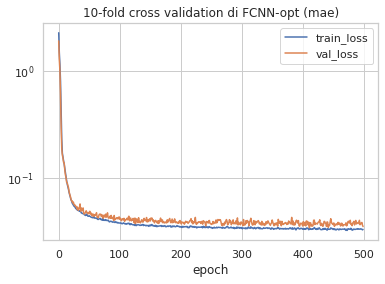

In [22]:
cv_res.groupby("epoch")[["train_loss", "val_loss"]].mean().plot(grid=True, logy=True)
plt.title(f"10-fold cross validation di FCNN-opt ({config['loss']})")
plt.show()

Epoch del minimo della funzione obiettivo, sarà usata successivamente per riaddestrare il modello.

In [23]:
best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
print("Best epoch", best_epoch)

Best epoch 411


Il modello ottimizzato ha tre hidden layer e usa MAE come loss function.

In [24]:
print(yaml.dump(config))

batch: 64
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 49
  - dropout: 0.0
    size: 13
  - dropout: 0.0
    size: 9
optimizer:
  lr: 0.001112253919985314
  name: adam
  weight_decay: 0.02564558837387174



Il modello viene riaddestrato usando tutto il training set, fino all'epoch che ha dato il miglior risultato durante l'HP tuning.

In [25]:
data = CosmoData(train_df, None, test_df, config["batch"])
model = CosmoPredictor(data.input_size, config)
train_res_opt = model.fit(data, best_epoch)
test_res_opt = model.test(data)

<AxesSubplot:>

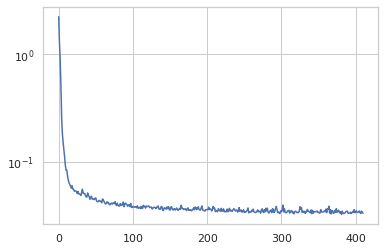

In [26]:
train_res_opt.train_loss.plot(grid=True, logy=True)

Si nota un miglioramento sia nell'errore assoluto che relativo rispetto al modello non ottimizzato. Si può notare un errore relativo massimo peggiore, ma un miglioramento fino al 75° percentile.

In [27]:
test_res_opt["abs_err"] = (test_res_opt.target - test_res_opt.prediction).abs()
test_res_opt["rel_err"] = test_res_opt.abs_err / test_res_opt.target
test_res_opt["residual"] = test_res_opt.target - test_res_opt.prediction
test_res_opt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,0.975465,0.037667
std,2.727806,0.057721
min,0.000029,0.000019
25%,0.071229,0.010714
50%,0.203525,0.024589
75%,0.737847,0.044197
max,47.801453,0.601792


Il RMSE è migliore rispetto al modello non ottimizzato e si discosta di 0.4 secondi (in più) rispetto al RMSE del cross-validation set.

In [28]:
print("RMSE:", np.sqrt((test_res_opt.abs_err ** 2).mean()))

RMSE: 2.895689896411255


Tuttavia, notiamo come il pattern nel confronto tra residuo e previsione siano inalterati nell'estremo superiore (seppure meno evidente)

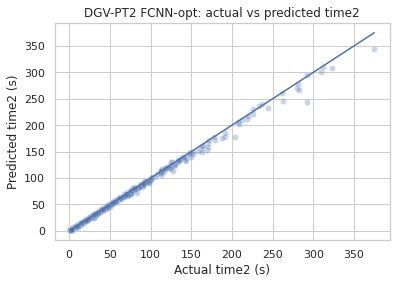

In [29]:
plt.title("DGV-PT2 FCNN-opt: actual vs predicted time2")
plt.plot([test_res_opt.target.min(), test_res_opt.target.max()], [test_res_opt.target.min(), test_res_opt.target.max()])
sns.scatterplot(x=test_res_opt.target, y=test_res_opt.prediction, alpha=0.3)
plt.xlabel("Actual time2 (s)")
plt.ylabel("Predicted time2 (s)")
plt.savefig("tex/images/dgv-pt2/fcnn-opt-correlazione-osservazione-previsione.pdf")
plt.show()

Il miglioramento si apprezza maggiormente nel grafico dei residui.

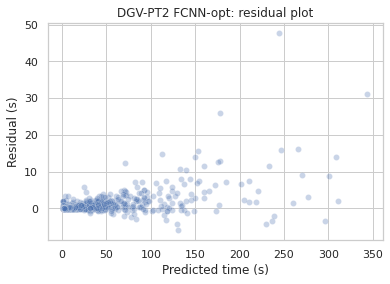

In [30]:
plt.title("DGV-PT2 FCNN-opt: residual plot")
sns.scatterplot(data=test_res_opt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgv-pt2/fcnn-opt-grafico-residui.pdf")
plt.show()

Di seguito, i valori di MAE, RMSE, MAPE dei 4 modelli, dove possiamo vedere come i due FCNN sono sensibilmente migliore degli altri 3 (in particolar modo quella ottimizzata).

In [31]:
for name, df in zip(("PO", "LR", "FCNN no-opt", "FCNN opt"), (test_res_oe, test_res_lr, test_res_noopt, test_res_opt)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE PO: 9.802852222337242
MAE LR: 10.2160770187178
MAE FCNN no-opt: 5.551619549095631
MAE FCNN opt: 0.9754654245972634


In [32]:
for name, df in zip(("PO", "LR", "FCNN no-opt", "FCNN opt"), (test_res_oe, test_res_lr, test_res_noopt, test_res_opt)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE PO: 21.58376307980503
RMSE LR: 25.347897114309816
RMSE FCNN no-opt: 15.642204439554213
RMSE FCNN opt: 2.895689896411255


In [33]:
for name, df in zip(("PO", "LR", "FCNN no-opt", "FCNN opt"), (test_res_oe, test_res_lr, test_res_noopt, test_res_opt)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE PO: 27.1032634377268
MAPE LR: 38.843096329532976
MAPE FCNN no-opt: 13.578382341279433
MAPE FCNN opt: 3.7666749903353827


Qui sotto, sono confrontati i grafici di correlazione tra errore assoluto e tempo osservato dei 4 modelli. Si può notare il netto miglioramento per i task con tempo maggiore e una ulteriore minimizzazione dell'errore nel caso dell'FCNN ottimizzato nella zona centrale del tempo osservato.

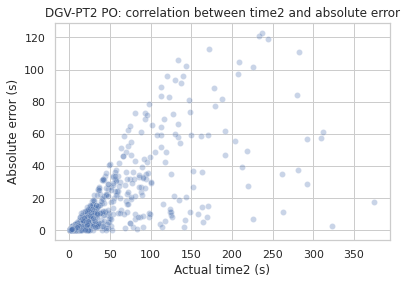

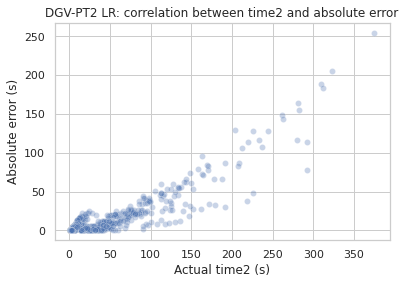

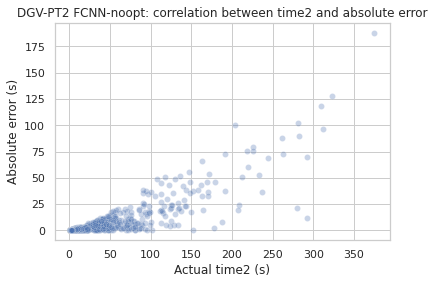

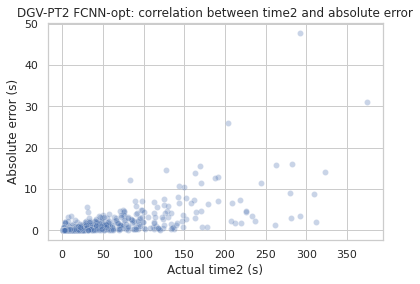

In [34]:
sns.scatterplot(x=test_res_oe.target, y=test_res_oe.abs_err, alpha=0.3)
plt.title("DGV-PT2 PO: correlation between time2 and absolute error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgv-pt2/po-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_lr.target, y=test_res_lr.abs_err, alpha=0.3)
plt.title("DGV-PT2 LR: correlation between time2 and absolute error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgv-pt2/lr-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.abs_err, alpha=0.3)
plt.title("DGV-PT2 FCNN-noopt: correlation between time2 and absolute error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgv-pt2/fcnn-noopt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_opt.target, y=test_res_opt.abs_err, alpha=0.3)
plt.title("DGV-PT2 FCNN-opt: correlation between time2 and absolute error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgv-pt2/fcnn-opt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

Qui sotto vediamo invece la correlazione con l'errore relativo: si nota come nel caso di LR l'errore sia alto nel caso di tempi brevi e poi torni a salire per i tempi più lunghi. Negli altri due casi, invece, si hanno risultati peggiori nel caso dei tempi brevi (ma significativamente migliori rispetto a LR) e non sia più presente un rapporto lineare tra errore relativo e tempo di esecuzione per i valori osservati più alti. Nel caso ottimizzato, gli errori sono sensibilmente migliori.

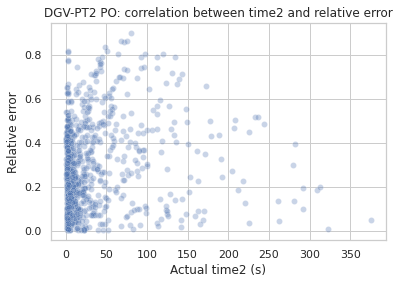

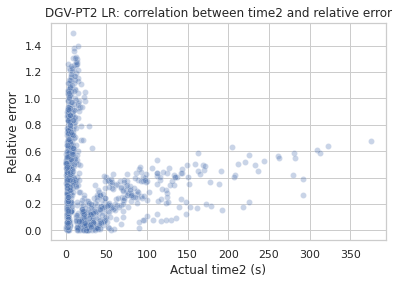

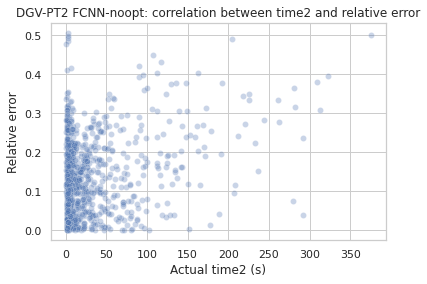

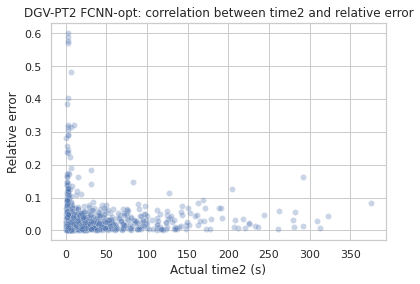

In [35]:
sns.scatterplot(x=test_res_oe.target, y=test_res_oe.rel_err, alpha=0.3)
plt.title("DGV-PT2 PO: correlation between time2 and relative error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgv-pt2/po-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_lr.target, y=test_res_lr.rel_err, alpha=0.3)
plt.title("DGV-PT2 LR: correlation between time2 and relative error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgv-pt2/lr-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.rel_err, alpha=0.3)
plt.title("DGV-PT2 FCNN-noopt: correlation between time2 and relative error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgv-pt2/fcnn-noopt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_opt.target, y=test_res_opt.rel_err, alpha=0.3)
plt.title("DGV-PT2 FCNN-opt: correlation between time2 and relative error")
plt.xlabel("Actual time2 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgv-pt2/fcnn-opt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

Di seguito, possiamo vedere le funzioni cumulative dell'errore assoluto e relativo nei 4 modelli studiati. Come si poteva già dedurre dalle precedenti osservazioni, i modelli FCNN sono migliori di PO e LR (in particolar modo per quanto riguarda l'errore relativo) e l'FCNN ottimizzato ha prestazioni migliori soprattutto per quanto riguarda l'errore assoluto.

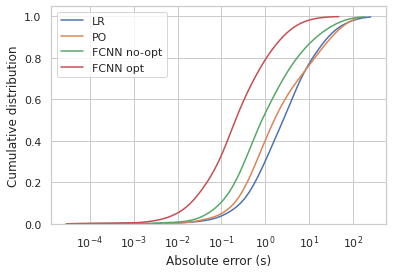

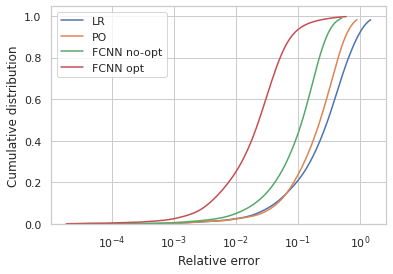

In [36]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_oe, x="abs_err", log_scale=True, cumulative=True, cut=0, label="PO")
sns.kdeplot(data=test_res_noopt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgv-pt2/cdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_oe, x="rel_err", log_scale=True, cumulative=True, cut=0, label="PO")
sns.kdeplot(data=test_res_noopt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.legend()
plt.savefig("tex/images/dgv-pt2/cdf-errore-relativo.pdf")
plt.show()

Nel caso della funzione di distribuzione dell'errore assoluto notiamo come FCNN ottimizzato non sia perfettamente monomodale, ma come il secondo picco sia comunque meno marcato rispetto alla versione non ottimizzata.

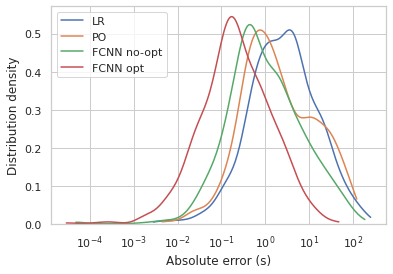

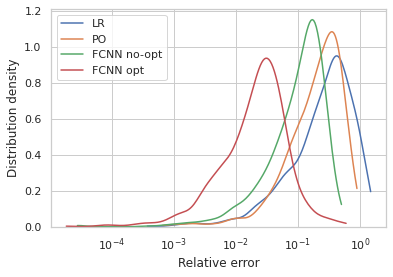

In [37]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_oe, x="abs_err", log_scale=True, cumulative=False, cut=0, label="PO")
sns.kdeplot(data=test_res_noopt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgv-pt2/pdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_oe, x="rel_err", log_scale=True, cumulative=False, cut=0, label="PO")
sns.kdeplot(data=test_res_noopt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.legend()
plt.savefig("tex/images/dgv-pt2/pdf-errore-relativo.pdf")
plt.show()

Qui sotto, si riportano i grafici dei tre modelli che mostrano il rapporto tra osservato e previsto, in modo da poterli confrontare più facilmente.

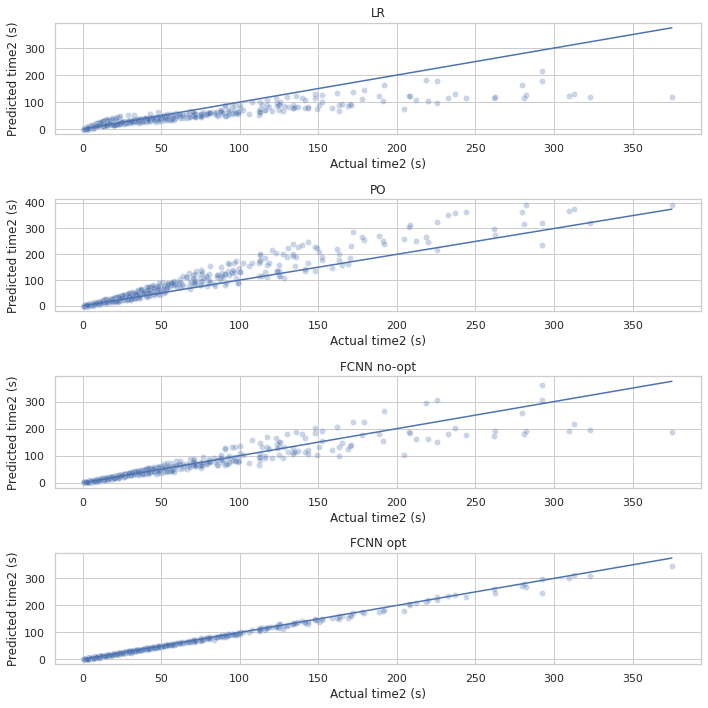

In [38]:
figure, axs = plt.subplots(4, figsize=(10, 10))

for ax, name, df in zip(axs, ("LR", "PO", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_oe, test_res_noopt, test_res_opt)):
    ax.set_title(f"{name}")
    ax.set_xlabel("Actual time2 (s)")
    ax.set_ylabel("Predicted time2 (s)")
    ax.plot([df.target.min(), df.target.max()], [df.target.min(), df.target.max()])
    sns.scatterplot(x=df.target, y=df.prediction, alpha=0.3, ax=ax)
    
figure.tight_layout()
plt.show()

## Conclusioni
Il modello ottimizzato ha prestazioni molto migliori rispetto non solo a LR e PO, ma anche rispetto all'FCNN non ottimizzato. Il 99% ha un errore assoluto minore di ~13 secondi e un errore relativo minore del ~31%.

Inoltre, nel 95% dei casi abbiamo un errore relativo massimo di ~11%: errori relativi maggiori sono sostanzialmente riferiti a esecuzioni brevi, dove un maggior errore ha meno impatto rispetto alle esecuzioni più lunghe.

In [39]:
test_res_opt[["abs_err", "rel_err"]].quantile([0.9, 0.95, 0.98, 0.99], interpolation="higher")

,abs_err,rel_err
0.90,2.312965,0.069016
0.95,4.211243,0.112464
0.98,7.949402,0.223583
0.99,12.905365,0.314811


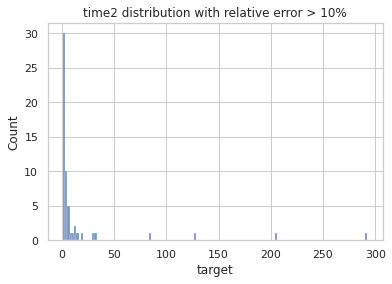

In [40]:
sns.histplot(data=test_res_opt.query("rel_err > 0.10"), x="target")
plt.title("time2 distribution with relative error > 10%")
plt.show()

Nel dataset è presente una evidente anomalia (job 989), che si può notare guardando la correlazione tra tempo osservato e errore relativo, in quanto è un job con un alto tempo di esecuzione (292.40 secondi) a cui corrisponde un alto errore assoluto (47.8 secondi), molto superiore a quello delle altre previsioni (il secondo peggior errore assoluto è di 31 secondi, ma ha un errore relativo di circa l'8%), e soprattutto un errore relativo del 16%, laddove nella parte alta dell'intervallo dei tempi di esecuzione è al massimo del 10%. Confrontando con un job con meno nodi e meno core per nodo, notiamo che i tempi sono gli stessi: di conseguenza, siamo in presenza di una anomalia.

In [41]:
pd.concat([test_df, test_res_opt], axis=1).query("x_length == 46000 and y_length == 14400 and grid_step == 20 and time2 >= 280 and time2 <= 300")

,x_length,y_length,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time2,target,prediction,abs_err,rel_err,residual
784,46000,14400,20,22,30,0,1.083333,292.26,292.260010,295.826202,3.566193,0.012202,-3.566193
989,46000,14400,20,25,36,0,2.250000,292.40,292.399933,244.598480,47.801453,0.163480,47.801453


Ad ulteriore conferma, prendiamo una anomalia dal dataset DGF (job 403). L'anomalia viene riconosciuta grazie a due indicatori:
* Il primo indizio è fornito dall'errore assoluto (46.09 secondi), che è maggiore di ogni previsione non anomala fatta sul test set.
* Il secondo indizio è fornito dall'errore relativo (41%), che per job con tempo di esecuzione maggiore di 10 secondi è minore del 20%.

In [42]:
anomaly_df = pd.read_csv(io.StringIO((
    "x_length,y_length,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time2\n"
    "10000,10000,20,14,32,0,1.8235294117647056,112.70"
)))

data = CosmoData(train_df, None, anomaly_df, "all")
anomaly_res_opt = model.test(data)

In [43]:
anomaly_res_opt

,target,prediction
0,112.70002,66.60585


In [44]:
print("Errore assoluto:", (anomaly_res_opt["target"] - anomaly_res_opt["prediction"]).abs())
print("Errore relativo:", ((anomaly_res_opt["target"] - anomaly_res_opt["prediction"])/anomaly_res_opt["target"]).abs())

Errore assoluto: 0    46.09417
dtype: float64
Errore relativo: 0    0.408999
dtype: float64
